**Step 0 - install and import dependencies**

In [1]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

In [1]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [2]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [3]:
df = pd.read_csv("Wongnai Reviews - Small.csv")

In [4]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


In [12]:
df['Review'] = df['Review'].apply(lambda x: emoji_pattern.sub(r'', x))
df['Review'] = df['Review'].apply(lambda x: specialchar_pattern.sub(r'', x))
df['Review'] = df['Review'].apply(lambda x: number_pattern.sub(r'', x))
df['Review'] = df['Review'].apply(lambda x: dot_pattern.sub(r'', x))
df['Review'] = df['Review'].apply(lambda x: backslash_pattern.sub(r'', x))

In [13]:
df

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...
...,...,...
295,296,ค่ำนี้คุณเพื่อนอยากส้มตำ หมูเฮาเลยพากันลงมากิน...
296,297,ร้านสะอาดดี ตกแต่งสวยงาม มีที่จอดรถ ราคาเมนูต่...
297,298,เช้าๆ รีบๆ วิ่งมาเข่าห้องเรียนแทบไม่ทันแต่ต้อง...
298,299,ร้านนี้เป็นร้านกาแฟเล็กๆ ข้างๆ ร้านๆ Happy Man...


**Step 1 - document embedding and dimension reduction**

In [14]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.09295429,  0.01656407,  0.02240348, ..., -0.01792794,
         0.05469173,  0.03123625],
       [ 0.00634244,  0.00814592,  0.03071937, ..., -0.01478722,
        -0.03080932, -0.03316409],
       [ 0.06373275, -0.02346725, -0.05199331, ..., -0.06501393,
        -0.01356405, -0.0334098 ],
       ...,
       [ 0.08775926,  0.03609738,  0.01263058, ..., -0.03102781,
        -0.03361676,  0.0192887 ],
       [ 0.05682085,  0.05065864, -0.03147017, ..., -0.06568728,
        -0.06059823, -0.01176483],
       [ 0.07980973,  0.05713337,  0.03519645, ..., -0.0072873 ,
        -0.04654042,  0.0270373 ]], dtype=float32)

In [15]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

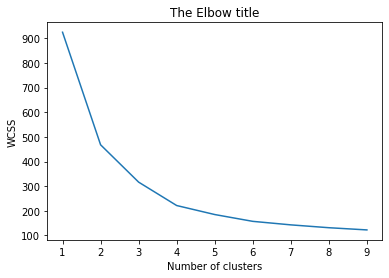

In [50]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [67]:
#run kmeans with no. of clusters you see fit the most

k = 5

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [68]:
df

,Review ID,Review,KMeans ID
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...,1
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...,1
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...,2
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,0
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...,0
...,...,...,...
295,296,ค่ำนี้คุณเพื่อนอยากส้มตำ หมูเฮาเลยพากันลงมากิน...,2
296,297,ร้านสะอาดดี ตกแต่งสวยงาม มีที่จอดรถ ราคาเมนูต่...,4
297,298,เช้าๆ รีบๆ วิ่งมาเข่าห้องเรียนแทบไม่ทันแต่ต้อง...,1
298,299,ร้านนี้เป็นร้านกาแฟเล็กๆ ข้างๆ ร้านๆ Happy Man...,1


In [69]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [70]:
df_kmeans

,KMeans ID,texts
0,0,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
1,1,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
2,2,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
3,3,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
4,4,11 โลตัสพัฒนาการมีร้านชีทเค้กน่าหม่ำอยู่ร้...


In [71]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [72]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [73]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [74]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [75]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [76]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [77]:
from pythainlp.tag.named_entity import ThaiNameTagger

ner = ThaiNameTagger()

In [78]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization
stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน','นะคะ']
screening_words = stopwords + removed_words

new_words = {"สตารบัก"}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words and len(word) > 1 and ner.get_ner(word)[0][1] != 'PA': # ตัดคำที่มี POS Tag เป็น PA เพราะไม่มีความสำคัญ (เช่นคำว่า ครับ ค่ะ)
      merged.append(word)
  return merged

In [79]:
df_kmeans

,KMeans ID,texts
0,0,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...
1,1,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
2,2,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
3,3,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
4,4,11 โลตัสพัฒนาการมีร้านชีทเค้กน่าหม่ำอยู่ร้...


In [80]:
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [81]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ,...","[(กิน, 12), (อร่อย, 8), (ผม, 7), (ทาน, 6), (กา..."
1,1,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, ทาน, Macchiato, เป็นประจำ, นึง, เด, ...","[(ร้านกาแฟ, 16), (กาแฟ, 15), (ทาน, 7), (แวะ, 6..."
2,2,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(ร้านอาหาร, 12), (อาหาร, 7), (อร่อย, 7), (กก,..."
3,3,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เป...,"[หลังอาหาร, มื้อ, ต่อให้, อิ่, เครื่องดื่ม, ขน...","[(ชา, 18), (ไข่มุก, 14), (นม, 13), (ทาน, 5), (..."
4,4,โลตัสพัฒนาการมีร้านชีทเค้กน่าหม่ำอยู่ร้านนึงค่...,"[โลตัส, พัฒนาการ, ชี, เค้ก, หม่ำ, นึง, ค่, ร้า...","[(ร้านกาแฟ, 7), (ทาน, 5), (เบเกอรี่, 4), (พาย,..."


In [82]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('กิน', 12), ('อร่อย', 8), ('ผม', 7), ('ทาน', 6), ('กาแฟ', 5), ('กก', 5), ('อาหาร', 4), ('บ้าน', 4), ('ครั้งแรก', 4), ('รีวิว', 4)]

Cluster ID : 1

Most common words include : [('ร้านกาแฟ', 16), ('กาแฟ', 15), ('ทาน', 7), ('แวะ', 6), ('กิน', 5), ('ชอบ', 4), ('แนว', 4), ('น่ารัก', 4), ('นั่ง', 4), ('สวัสดี', 4)]

Cluster ID : 2

Most common words include : [('ร้านอาหาร', 12), ('อาหาร', 7), ('อร่อย', 7), ('กก', 7), ('ทาน', 6), ('ซอย', 6), ('ส้มตำ', 5), ('กิน', 5), ('รีวิว', 4), ('ไทย', 4)]

Cluster ID : 3

Most common words include : [('ชา', 18), ('ไข่มุก', 14), ('นม', 13), ('ทาน', 5), ('เครื่องดื่ม', 4), ('ตั้งอยู่', 3), ('ลอง', 3), ('เดิน', 3), ('ไต้หวัน', 3), ('ชาเขียว', 2)]

Cluster ID : 4

Most common words include : [('ร้านกาแฟ', 7), ('ทาน', 5), ('เบเกอรี่', 4), ('พาย', 4), ('ชอบ', 4), ('เค้ก', 3), ('กา', 3), ('คาเฟ่', 3), ('เจอ', 3), ('กาแฟ', 3)]



Cluster 0 = รีวิวร้านอาหารทั่วไป
Cluster 1 = รีวิวร้านกาแฟ ร้านสวน นั่ง + ถ่ายรูป
Cluster 2 = รีวิวร้านส้มตำ
Cluster 3 = รีวิวร้านชานมไข่มุก
Cluster 4 = รีวิวร้านกาแฟ + เบเกอรี่